<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Box Score Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Fixed Window Forecasting</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [3]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_box_scores_2022_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    feature_prefixes=['ROLL_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [4]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [5]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.296,0.753,0.758,0.580,0.731,0.805,0.878,0.535,0.571,0.292,0.478,0.612,1.000,1.000,0.600,0.661,0.577,0.586,0.202,0.704,0.526,0.176,1.000,0.336,0.285,0.603,0.250,0.369,0.291,0.500,0.28,0.5,0.391,0.500,185
2021-10-23,0.000,0.000,0.648,0.000,0.076,0.412,0.000,0.466,0.534,0.438,1.000,0.381,0.826,0.000,0.420,0.273,0.657,0.576,0.096,0.017,0.362,0.000,0.421,0.588,0.364,0.294,0.163,0.837,0.312,0.685,0.606,0.083,0.28,0.3,0.348,0.571,198
2021-10-23,0.691,0.652,0.507,0.758,0.455,0.454,0.466,0.593,0.534,0.720,0.286,0.602,0.609,0.561,0.058,0.364,0.257,0.661,0.635,0.586,0.176,0.728,0.263,0.265,0.396,0.672,0.772,0.469,0.125,0.685,0.488,0.708,0.36,0.2,0.174,0.643,239
2021-10-23,0.727,0.826,0.683,0.827,0.530,0.244,0.772,0.297,0.382,0.315,0.571,0.159,0.348,0.918,0.275,0.182,0.029,0.661,0.250,0.069,0.122,0.225,0.368,0.559,0.317,0.588,0.813,0.268,0.000,0.369,0.134,0.208,0.20,0.0,0.348,0.929,232
2021-10-24,0.745,0.783,0.577,0.848,0.833,0.580,0.820,0.254,0.229,0.560,0.357,0.779,0.826,0.765,0.565,0.818,0.543,0.322,1.000,0.897,1.000,0.362,0.842,1.000,0.559,0.504,0.569,0.446,0.625,0.730,0.843,0.833,0.76,0.9,0.478,0.786,204


In [6]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.296,0.753,0.758,0.580,0.731,0.805,0.878,0.535,0.571,0.292,0.478,0.612,1.000,1.000,0.600,0.661,0.577,0.586,0.202,0.704,0.526,0.176,1.000,0.336,0.285,0.603,0.250,0.369,0.291,0.500,0.28,0.5,0.391,0.500,7.0
2021-10-23,0.000,0.000,0.648,0.000,0.076,0.412,0.000,0.466,0.534,0.438,1.000,0.381,0.826,0.000,0.420,0.273,0.657,0.576,0.096,0.017,0.362,0.000,0.421,0.588,0.364,0.294,0.163,0.837,0.312,0.685,0.606,0.083,0.28,0.3,0.348,0.571,-8.0
2021-10-23,0.691,0.652,0.507,0.758,0.455,0.454,0.466,0.593,0.534,0.720,0.286,0.602,0.609,0.561,0.058,0.364,0.257,0.661,0.635,0.586,0.176,0.728,0.263,0.265,0.396,0.672,0.772,0.469,0.125,0.685,0.488,0.708,0.36,0.2,0.174,0.643,29.0
2021-10-23,0.727,0.826,0.683,0.827,0.530,0.244,0.772,0.297,0.382,0.315,0.571,0.159,0.348,0.918,0.275,0.182,0.029,0.661,0.250,0.069,0.122,0.225,0.368,0.559,0.317,0.588,0.813,0.268,0.000,0.369,0.134,0.208,0.20,0.0,0.348,0.929,-10.0
2021-10-24,0.745,0.783,0.577,0.848,0.833,0.580,0.820,0.254,0.229,0.560,0.357,0.779,0.826,0.765,0.565,0.818,0.543,0.322,1.000,0.897,1.000,0.362,0.842,1.000,0.559,0.504,0.569,0.446,0.625,0.730,0.843,0.833,0.76,0.9,0.478,0.786,-10.0


In [7]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.745,0.522,0.296,0.753,0.758,0.580,0.731,0.805,0.878,0.535,0.571,0.292,0.478,0.612,1.000,1.000,0.600,0.661,0.577,0.586,0.202,0.704,0.526,0.176,1.000,0.336,0.285,0.603,0.250,0.369,0.291,0.500,0.28,0.5,0.391,0.500,1
2021-10-23,0.000,0.000,0.648,0.000,0.076,0.412,0.000,0.466,0.534,0.438,1.000,0.381,0.826,0.000,0.420,0.273,0.657,0.576,0.096,0.017,0.362,0.000,0.421,0.588,0.364,0.294,0.163,0.837,0.312,0.685,0.606,0.083,0.28,0.3,0.348,0.571,0
2021-10-23,0.691,0.652,0.507,0.758,0.455,0.454,0.466,0.593,0.534,0.720,0.286,0.602,0.609,0.561,0.058,0.364,0.257,0.661,0.635,0.586,0.176,0.728,0.263,0.265,0.396,0.672,0.772,0.469,0.125,0.685,0.488,0.708,0.36,0.2,0.174,0.643,1
2021-10-23,0.727,0.826,0.683,0.827,0.530,0.244,0.772,0.297,0.382,0.315,0.571,0.159,0.348,0.918,0.275,0.182,0.029,0.661,0.250,0.069,0.122,0.225,0.368,0.559,0.317,0.588,0.813,0.268,0.000,0.369,0.134,0.208,0.20,0.0,0.348,0.929,0
2021-10-24,0.745,0.783,0.577,0.848,0.833,0.580,0.820,0.254,0.229,0.560,0.357,0.779,0.826,0.765,0.565,0.818,0.543,0.322,1.000,0.897,1.000,0.362,0.842,1.000,0.559,0.504,0.569,0.446,0.625,0.730,0.843,0.833,0.76,0.9,0.478,0.786,0


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [8]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pts_scaled_df.drop('TOTAL_PTS', axis=1),
    pts_scaled_df['TOTAL_PTS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 36) (2367,) (692, 36) (692,)


In [9]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 53.80 seconds


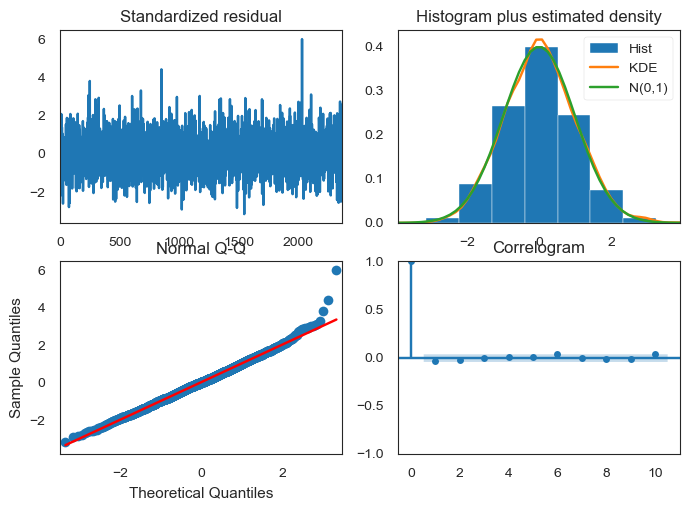

In [10]:
model1.plot_diagnostics();

In [11]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -10296.983
Date:                Tue, 05 Mar 2024   AIC                          20669.966
Time:                        14:44:23   BIC                          20889.187
Sample:                             0   HQIC                         20749.777
                               - 2367                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ROLL_HOME_PTS      6.558e+04     21.927   2990.752      0.000    6.55e+04    6.56e+04
ROLL_HOME_FGM     -5.476e+04     32.259  -1697.475      0.000   -5.48e+04   -5.47e+04
ROLL_HOME_FGA       -23.4723     29.003     -0.809      0.418     -80.318      33.373
ROLL_HOME_FG_PCT    -60.6307     43.375     -1.398      0.162    -145.644      24.383
ROLL_HOME_FG3M     -1.57e+04     21.724   -722.761      0.000   -1.57e+04   -1.57e+04
ROLL_HOME_FG3A      -21.2805     13.742     -1.549      0.121     -48.214       5.653
ROLL_HOME_FG3_PCT   -35.7496     15.497     -2.307      0.021     -66.123      -5.376
ROLL_HOME_FTM     -2.814e+04     25.169  -1117.881      0.000   -2.82e+04   -2.81e+04
ROLL_HOME_FTA        10.0264     22.738      0.441      0.659     -34.540      54.593
ROLL_HOME_FT_PCT      0.3533     12.389      0.029      0.977     -23.928      24.635
ROLL_HOME_OREB     8.705e+04      3.229    2.7e+04      0.000     8.7e+04    8.71e+04
ROLL_HOME_DREB     1.405e+05      2.093   6.71e+04      0.000    1.41e+05    1.41e+05
ROLL_HOME_REB      -1.43e+05      1.790  -7.99e+04      0.000   -1.43e+05   -1.43e+05
ROLL_HOME_AST         1.9138      3.734      0.513      0.608      -5.405       9.233
ROLL_HOME_STL       -10.0351      3.841     -2.613      0.009     -17.563      -2.507
ROLL_HOME_BLK         6.4429      3.395      1.898      0.058      -0.211      13.097
ROLL_HOME_TOV         8.8959      3.885      2.290      0.022       1.281      16.510
ROLL_HOME_PF         -2.1430      2.532     -0.846      0.397      -7.107       2.820
ROLL_AWAY_PTS      2.006e+04     18.582   1079.441      0.000       2e+04    2.01e+04
ROLL_AWAY_FGM     -1.485e+04     31.817   -466.895      0.000   -1.49e+04   -1.48e+04
ROLL_AWAY_FGA       -20.1112     38.538     -0.522      0.602     -95.643      55.421
ROLL_AWAY_FG_PCT    -46.2359     41.806     -1.106      0.269    -128.174      35.702
ROLL_AWAY_FG3M    -7327.1433     29.839   -245.554      0.000   -7385.627   -7268.659
ROLL_AWAY_FG3A        8.3427     19.913      0.419      0.675     -30.687      47.372
ROLL_AWAY_FG3_PCT    -8.6858     17.735     -0.490      0.624     -43.446      26.074
ROLL_AWAY_FTM     -9136.9593     25.389   -359.880      0.000   -9186.721   -9087.198
ROLL_AWAY_FTA       -26.0459     22.106     -1.178      0.239     -69.373      17.282
ROLL_AWAY_FT_PCT    -16.7639     11.637     -1.441      0.150     -39.573       6.045
ROLL_AWAY_OREB     1.394e+05      3.341   4.17e+04      0.000    1.39e+05    1.39e+05
ROLL_AWAY_DREB     1.934e+05      2.257   8.57e+04      0.000    1.93e+05    1.93e+05
ROLL_AWAY_REB     -2.213e+05      2.123  -1.04e+05      0.000   -2.21e+05   -2.21e+05
ROLL_AWAY_AST         2.8548      4.716      0.605      0.545      -6.388      12.098
ROLL_AWAY_STL        -8.6522      3.734     -2.317      0.020     -15.971      -1.334
ROLL_AWAY_BLK         4.4981      3.274      1.374      0.169      -1.918      10.914
ROLL_AWAY_TOV        17.3248      4.938      3.509      0.0

In [12]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 6.57 %
Root Mean Squared Error: 18.99


No supported index is available. Prediction results will be given with an integer index beginning at `start`.


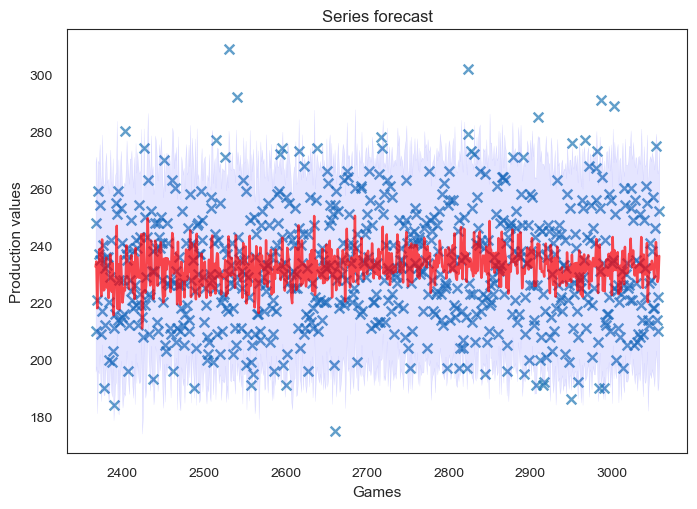

In [13]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_scaled_df['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [15]:
# split the data
X_train, X_test, y_train, y_test = pm_train_test_split(
    pm_scaled_df.drop('PLUS_MINUS', axis=1),
    pm_scaled_df['PLUS_MINUS'], 
    train_size=season_22_ngames+season_23_ngames
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2367, 36) (2367,) (692, 36) (692,)


In [16]:
start_time = time.time()

# fit models
model1 = pm.auto_arima(
    y=y_train, 
    X=X_train,
    start_p=1, max_p=20,
    start_q=1, max_q=5,
    max_d=3,   max_D=2,
    start_P=1, max_P=2,
    start_Q=1, max_Q=2,
    max_order=None,
    seasonal=False,
    stationary=False,
    information_criterion='aic',
    stepwise=True)

arimax_residuals = model1.resid()

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

Total time taken: 34.30 seconds


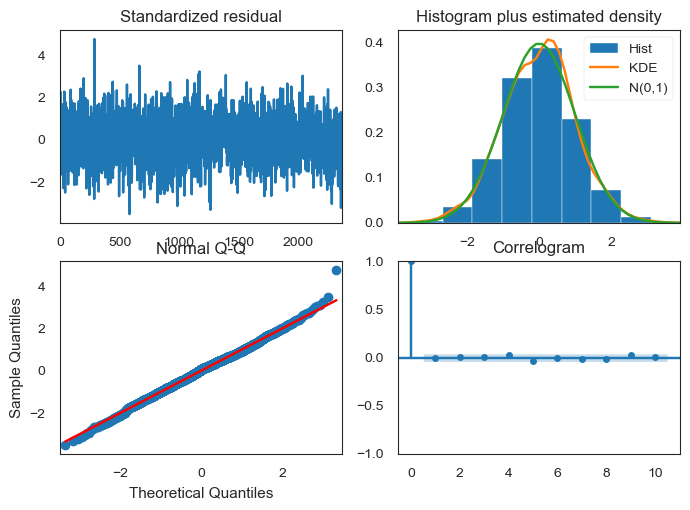

In [17]:
model1.plot_diagnostics();

In [18]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2367
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9590.104
Date:                Tue, 05 Mar 2024   AIC                          19258.207
Time:                        14:47:24   BIC                          19483.213
Sample:                             0   HQIC                         19340.122
                               - 2367                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ROLL_HOME_PTS     -3.057e+04   1.39e+05     -0.220      0.826   -3.03e+05    2.42e+05
ROLL_HOME_FGM      2.561e+04   1.16e+05      0.220      0.826   -2.02e+05    2.53e+05
ROLL_HOME_FGA       -33.7895     21.956     -1.539      0.124     -76.822       9.243
ROLL_HOME_FG_PCT    -17.9814     33.065     -0.544      0.587     -82.788      46.825
ROLL_HOME_FG3M     7328.6689   3.34e+04      0.220      0.826   -5.81e+04    7.27e+04
ROLL_HOME_FG3A       12.3053      9.971      1.234      0.217      -7.238      31.849
ROLL_HOME_FG3_PCT     7.4951     11.219      0.668      0.504     -14.494      29.485
ROLL_HOME_FTM      1.313e+04   5.96e+04      0.220      0.826   -1.04e+05     1.3e+05
ROLL_HOME_FTA       -13.8609     16.958     -0.817      0.414     -47.097      19.375
ROLL_HOME_FT_PCT     -7.4263      8.806     -0.843      0.399     -24.686       9.833
ROLL_HOME_OREB     1103.2202   6.62e+04      0.017      0.987   -1.29e+05    1.31e+05
ROLL_HOME_DREB     1775.3101   1.07e+05      0.017      0.987   -2.08e+05    2.11e+05
ROLL_HOME_REB     -1797.2664   1.09e+05     -0.017      0.987   -2.15e+05    2.11e+05
ROLL_HOME_AST         3.3246      2.796      1.189      0.234      -2.155       8.804
ROLL_HOME_STL         8.8458      2.954      2.995      0.003       3.057      14.635
ROLL_HOME_BLK        -0.2260      2.582     -0.088      0.930      -5.287       4.835
ROLL_HOME_TOV       -11.6879      2.927     -3.993      0.000     -17.425      -5.950
ROLL_HOME_PF         -0.3510      1.918     -0.183      0.855      -4.111       3.409
ROLL_AWAY_PTS      4.953e+04   1.23e+05      0.401      0.688   -1.92e+05    2.91e+05
ROLL_AWAY_FGM     -3.687e+04   9.18e+04     -0.402      0.688   -2.17e+05    1.43e+05
ROLL_AWAY_FGA        52.8274     28.581      1.848      0.065      -3.191     108.846
ROLL_AWAY_FG_PCT     38.0938     30.746      1.239      0.215     -22.167      98.355
ROLL_AWAY_FG3M     -1.81e+04   4.51e+04     -0.401      0.688   -1.06e+05    7.03e+04
ROLL_AWAY_FG3A       -4.6098     14.081     -0.327      0.743     -32.208      22.989
ROLL_AWAY_FG3_PCT     0.2444     12.676      0.019      0.985     -24.601      25.090
ROLL_AWAY_FTM     -2.268e+04   5.65e+04     -0.402      0.688   -1.33e+05     8.8e+04
ROLL_AWAY_FTA        11.0466     17.943      0.616      0.538     -24.121      46.214
ROLL_AWAY_FT_PCT     -7.3637      9.561     -0.770      0.441     -26.103      11.375
ROLL_AWAY_OREB     1.069e+04   5.26e+04      0.203      0.839   -9.24e+04    1.14e+05
ROLL_AWAY_DREB     1.483e+04   7.29e+04      0.203      0.839   -1.28e+05    1.58e+05
ROLL_AWAY_REB     -1.698e+04   8.35e+04     -0.203      0.839   -1.81e+05    1.47e+05
ROLL_AWAY_AST        -4.6223      3.361     -1.375      0.169     -11.209       1.964
ROLL_AWAY_STL        -5.1517      2.465     -2.090      0.037      -9.983      -0.320
ROLL_AWAY_BLK        -3.8355      2.333     -1.644      0.100      -8.408       0.737
ROLL_AWAY_TOV        18.4436      3.653      5.048      0.0

In [19]:
# forecast mean (mu) and CI 
mu_forecast, mu_conf_int = model1.predict(
    n_periods=y_test.shape[0], 
    X=X_test,
    return_conf_int=True
)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")
# RMSE
print("Root Mean Squared Error:", round(mean_squared_error(y_test, mu_forecast, squared=False), 2))

Symmetric Mean Absolute Percentage Error: 140.31 %
Root Mean Squared Error: 14.55


No supported index is available. Prediction results will be given with an integer index beginning at `start`.


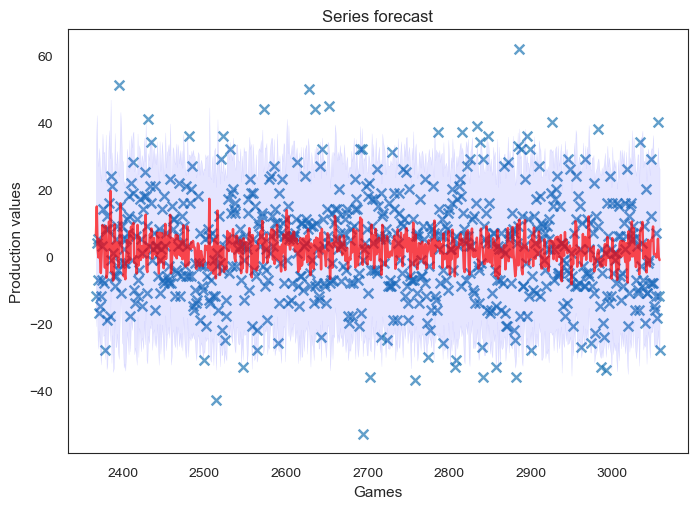

In [20]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(pts_scaled_df['TOTAL_PTS'].shape[0])
#plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Games')
plt.ylabel('Production values')
plt.show();